# XSS Attack

In [3]:
import pandas as pd
import urllib.request
import json
import pycountry 
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
import re
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import folium
from geonamescache import GeonamesCache
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

## Fetch data from url

In [4]:
url1 = "https://raw.githubusercontent.com/ayedaemon/RuckSack-Python/master/log_analysis/access_log"
url2 = "https://raw.githubusercontent.com/ayedaemon/RuckSack-Python/master/log_analysis/access_log2"
url3 = "https://github.com/robert456456456456/Web_server_log_parser/blob/master/devops.log"
urls=[url1,url2,url3]

In [5]:
logs=[]
for i,url in enumerate(urls):
    content=requests.get(url)
    data=(content.content.decode('UTF-8'))
    if(i==2):
        data=data.split("\r\n")
    else:
        data=data.split("\n")
    data.pop()
    logs.append(data)
    log = [x for s in logs for x in s]

In [6]:
log[0]

'127.0.0.1 - - [15/Jan/2021:08:54:07 +0000] "GET / HTTP/1.1" 403 4006 "-" "curl/7.61.1"'

In [7]:
def extractinfo(x):
    ip=x.split(" - - [",1)[0]
    x=x.split(" - - [",1)[1]
    time=x.split(" ",1)[0]
    gmtoffset=x.split("] ",1)[0]
    x=x.split('] "',1)[1]
    try:
        action=x.split(' HTTP/1.')[0]
        x=x.split(' HTTP/1.')[1]
        x=x.split('" ')[1]
    except:
        action=x.split('" ')[0]
        x=x.split('" ')[1]
    rcode=x.split(" ",1)[0]
    size=x.split(" ",1)[1]
    return [ip,time,gmtoffset,action,rcode,size]    

In [8]:
cleandata=[]
for i in log:
    cleandata.append(extractinfo(i))

In [9]:
cleandata[0]

['127.0.0.1',
 '15/Jan/2021:08:54:07',
 '15/Jan/2021:08:54:07 +0000',
 'GET /',
 '403',
 '4006 "-']

In [10]:
def extractipandwebsite(log):
    ips = []
    website = []
    regexp="(.*?)- -"
    re2='(GET|POST|OPTIONS|HEAD)(.*?)(HTTP)'
    re3='(GET|POST|OPTIONS|HEAD)(.*?)(")'
    re4='(")(.*?)(")'
    for j,i in enumerate(log):
        ips.append(re.findall(regexp,i))
        try:
            website.append(re.findall(re2,i)[0][1])
        except:
            try:
                website.append(re.findall(re3,i)[0][1])
            except:
                w = (re.findall(re4,i)[0][1])
                if w == "-":
                    website.append("none")
    return ips,website

def extract_time(log):
    time = []
    regexp='\[(.*?)\]'
    for j,i in enumerate(log):
        time.append(re.findall(regexp,i)[0])
    return time
def get_location(ip):
    response = requests.get("https://geolocation-db.com/json/c0593a60-4159-11eb-80cd-db15f946225f/{}&postion=true".format(ip)).json()
    return response['country_name']

In [11]:
e_ip,e_web = extractipandwebsite(log)
times = extract_time(log)
e_ip = [i[0].strip() for i in e_ip]

In [12]:
country = []
present = []
generated = []
for i in tqdm(e_ip):
    if i not in present:
        present.append(i)
        location = get_location(i)
        generated.append([i,location])
        country.append(location)
    else:
        for k in generated:
            if k[0]==i:
                country.append(location)

In [13]:
contry = country.copy()
for i,j in enumerate(contry):
    if j == "Not found":
        contry[i] = "NAA"

In [14]:
df = pd.DataFrame(data=e_ip,columns=["ip"])
df['website'] = e_web
df['time'] = times
df['Country'] = contry
df.head()

,ip,website,time,Country
0,127.0.0.1,/,15/Jan/2021:08:54:07 +0000,NAA
1,127.0.0.1,/cgi-bin/weakform.py,15/Jan/2021:08:55:23 +0000,NAA
2,127.0.0.1,/cgi-bin/weak_form.py,15/Jan/2021:09:01:38 +0000,NAA
3,212.92.37.62,/,15/Jan/2021:09:02:14 +0000,Spain
4,212.92.37.62,/noindex/common/css/bootstrap.min.css,15/Jan/2021:09:02:15 +0000,Spain


## Top visiters IP/User  address:

In [15]:
df['ip'].value_counts().head(5)

64.242.88.10      680
lordgun.org       617
207.195.59.160    222
219.95.17.51      214
212.92.37.62       59
Name: ip, dtype: int64

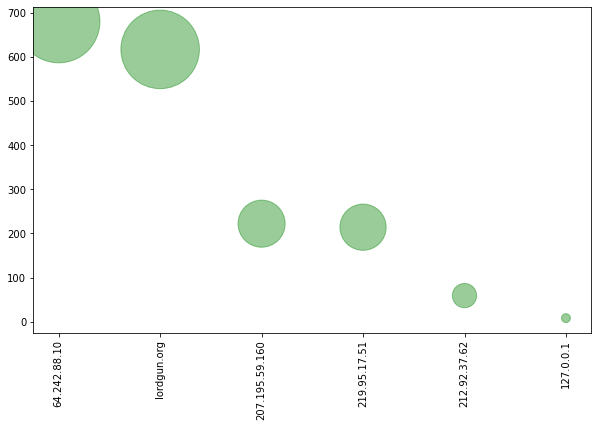

In [16]:
plt.figure(figsize = (10,6))

plt.scatter(df['ip'].value_counts().index[0:7],
            df['ip'].value_counts().values[0:7],
            s =  df['ip'].value_counts().values[0:7]*10,
                  color='green', 
                 alpha=0.4)

plt.xticks( df['ip'].value_counts().index[0:7],rotation='vertical');

## Most Frequently visited pages

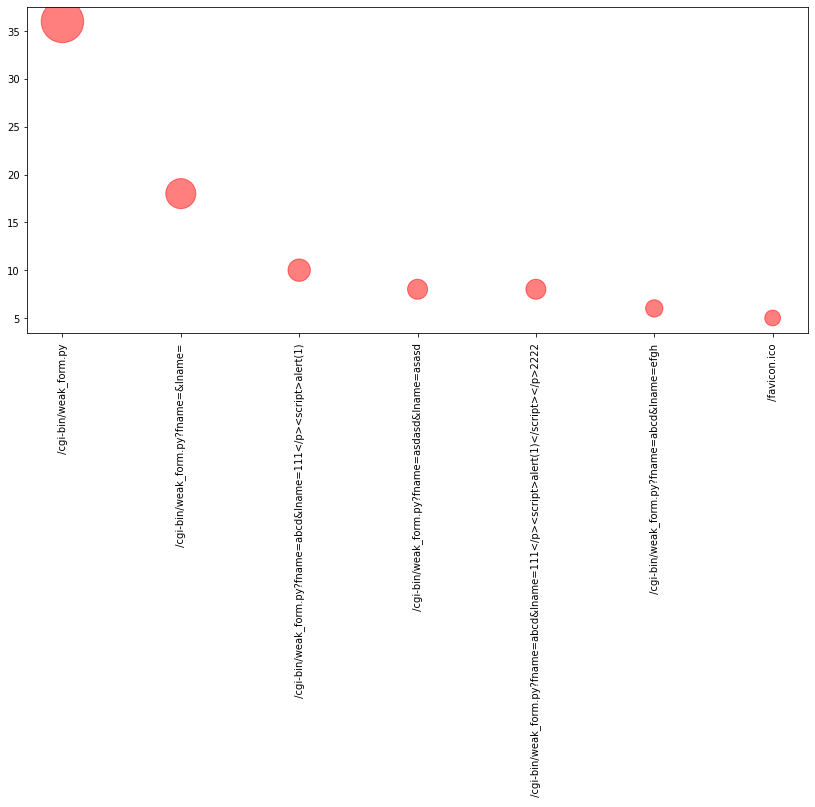

In [17]:
plt.figure(figsize = (14,6))

plt.scatter(df['website'].value_counts().index[0:7],
            df['website'].value_counts().values[0:7],
            s =  df['website'].value_counts().values[0:7]*50,
                  color='red', 
                 alpha=0.5)

plt.xticks( df['website'].value_counts().index[0:7],rotation='vertical');

## XSS attack detection

In [18]:
def findxss(str_):
    flag = 0
    l1 = ['<','>','\\','`']
    l2 = ['/',')','(']
    for char in l1:
        aasci_encoding = '%'+hex(ord(char)).replace('0x','')
        if (char in str_) or (aasci_encoding in str_):
            flag = 1
            break
    if flag != 1:
        try:
            req_str = ''.join(str_.split('?')[1:])
            for char in l2:
                aasci_encoding = '%'+hex(ord(char)).replace('0x','')
                if (char in req_str) or (aasci_encoding in req_str):
                    flag = 1
                    break
        except:
            pass
    return bool(flag)

In [19]:
df['XSS_attack'] = df['website'].apply(findxss)
df[df['XSS_attack']==True]

,ip,website,time,Country,XSS_attack
754,207.195.59.160,/cgi-bin/weak_form.py?fname=asdasd%3C%2Fp%3E%...,15/Jan/2021:10:05:35 +0000,United States,True
757,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:29:02 +0000,United States,True
758,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:04 +0000,United States,True
759,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:42 +0000,United States,True
760,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:30:57 +0000,United States,True
761,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:04 +0000,United States,True
762,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:24 +0000,United States,True
763,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:28 +0000,United States,True
764,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:31:34 +0000,United States,True
765,207.195.59.160,/cgi-bin/weak_form.py?fname=abcd&lname=111</p...,16/Jan/2021:05:32:02 +0000,United States,True


In [20]:
df['XSS_attack'].value_counts()

False    1752
True       48
Name: XSS_attack, dtype: int64

## Graph of user by location

In [21]:
locate=pd.Series(contry)
freq_locate=locate.value_counts()
locate_index=list(freq_locate.index)
freq_locate=list(freq_locate)
geodata=[]
for i in range(len(locate_index)):
    temp=[locate_index[i]]*freq_locate[i]
    geodata.append(temp)
flat_list = [item for sublist in geodata for item in sublist]
gc = GeonamesCache()
iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

In [22]:
locate_index

['India', 'United States', 'Malaysia', 'Spain', 'Canada', 'NAA']

In [23]:
loc_codes=['IND','USA','CAN','ESP','AUS','SVN','DEU','CHN','NLD','PHL','GBR','MYS','AUT','BRA']
locate_index.remove('NAA')
newlist=[i for i in flat_list if i!='Not found']
codes=[]
for i in newlist:
    for j in range(len(locate_index)):
        if i==locate_index[j]:
            codes.append(loc_codes[j])

In [24]:
world_map= folium.Map(control_scale=True)
marker_cluster = MarkerCluster().add_to(world_map)
geolocator = Nominatim(user_agent="myappname")
def geolocate(country):
    try:
        loc = geolocator.geocode(country)
        return (loc.latitude, loc.longitude)
    except:
        return np.nan
latitude=[]
longitude=[]
counter=0
for i in loc_codes:
    temp=geolocate(i)
    latitude.append(temp[0])
    longitude.append(temp[1])
    counter+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [25]:
newlati=[]
newlongi=[]
for i in codes:
    for j in range(len(loc_codes)):
        if i==loc_codes[j]:
            newlati.append(latitude[j])
            newlongi.append(longitude[j])

for i in range(len(newlati)):
        lat = newlati[i]
        long = newlongi[i]
        radius=4
        folium.CircleMarker(location = [lat, long], radius=radius).add_to(marker_cluster)
world_map

In [27]:
df

,ip,website,time,Country,XSS_attack
0,127.0.0.1,/,15/Jan/2021:08:54:07 +0000,NAA,False
1,127.0.0.1,/cgi-bin/weakform.py,15/Jan/2021:08:55:23 +0000,NAA,False
2,127.0.0.1,/cgi-bin/weak_form.py,15/Jan/2021:09:01:38 +0000,NAA,False
3,212.92.37.62,/,15/Jan/2021:09:02:14 +0000,Spain,False
4,212.92.37.62,/noindex/common/css/bootstrap.min.css,15/Jan/2021:09:02:15 +0000,Spain,False
...,...,...,...,...,...
1795,lordgun.org,/cgi-bin/weak_form.py?TWKAXWKIA=KOC,16/Jan/2021:13:02:17 +0000,India,False
1796,lordgun.org,/cgi-bin/weak_form.py?TRHYOWPDR=HRBCPR,16/Jan/2021:13:02:18 +0000,India,False
1797,lordgun.org,/cgi-bin/weak_form.py?OQUED=RCPFFTG,16/Jan/2021:13:02:21 +0000,India,False
1798,lordgun.org,/cgi-bin/weak_form.py?JVCSMGFH=CCJ,16/Jan/2021:13:02:18 +0000,India,False


In [52]:
doss=[]
for i in range(len(cleandata)):
    if re.search("^5.*",cleandata[i][4]):
        doss.append(cleandata[i])

In [53]:
doss

[['207.195.59.160',
  '15/Jan/2021:09:56:25',
  '15/Jan/2021:09:56:25 +0000',
  'GET /cgi-bin/weak_form.py?fname=&lname=',
  '500',
  '527 "http://172.17.0.2/cgi-bin/weak_form.py?fname=&lname='],
 ['207.195.59.160',
  '15/Jan/2021:09:58:49',
  '15/Jan/2021:09:58:49 +0000',
  'GET /cgi-bin/weak_form.py?fname=&lname=',
  '500',
  '527 "http://172.17.0.2/cgi-bin/weak_form.py?fname=&lname='],
 ['207.195.59.160',
  '15/Jan/2021:09:59:17',
  '15/Jan/2021:09:59:17 +0000',
  'GET /cgi-bin/weak_form.py?fname=&lname=',
  '500',
  '527 "http://172.17.0.2/cgi-bin/weak_form.py?fname=&lname='],
 ['207.195.59.160',
  '15/Jan/2021:09:59:23',
  '15/Jan/2021:09:59:23 +0000',
  'GET /cgi-bin/weak_form.py?fname=&lname=',
  '500',
  '527 "http://172.17.0.2/cgi-bin/weak_form.py'],
 ['207.195.59.160',
  '15/Jan/2021:09:59:34',
  '15/Jan/2021:09:59:34 +0000',
  'GET /cgi-bin/weak_form.py?fname=asdasd&lname=asasd',
  '500',
  '527 "http://172.17.0.2/cgi-bin/weak_form.py'],
 ['lordgun.org',
  '15/Jan/2021:09:56

In [57]:
dff=pd.DataFrame(doss)
dff

,0,1,2,3,4,5
0,207.195.59.160,15/Jan/2021:09:56:25,15/Jan/2021:09:56:25 +0000,GET /cgi-bin/weak_form.py?fname=&lname=,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py?fn..."
1,207.195.59.160,15/Jan/2021:09:58:49,15/Jan/2021:09:58:49 +0000,GET /cgi-bin/weak_form.py?fname=&lname=,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py?fn..."
2,207.195.59.160,15/Jan/2021:09:59:17,15/Jan/2021:09:59:17 +0000,GET /cgi-bin/weak_form.py?fname=&lname=,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py?fn..."
3,207.195.59.160,15/Jan/2021:09:59:23,15/Jan/2021:09:59:23 +0000,GET /cgi-bin/weak_form.py?fname=&lname=,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py"
4,207.195.59.160,15/Jan/2021:09:59:34,15/Jan/2021:09:59:34 +0000,GET /cgi-bin/weak_form.py?fname=asdasd&lname=a...,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py"
5,lordgun.org,15/Jan/2021:09:56:25,15/Jan/2021:09:56:25 +0000,GET /cgi-bin/weak_form.py?fname=&lname=,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py?fn..."
6,lordgun.org,15/Jan/2021:09:58:49,15/Jan/2021:09:58:49 +0000,GET /cgi-bin/weak_form.py?fname=&lname=,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py?fn..."
7,lordgun.org,15/Jan/2021:09:59:17,15/Jan/2021:09:59:17 +0000,GET /cgi-bin/weak_form.py?fname=&lname=,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py?fn..."
8,lordgun.org,15/Jan/2021:09:59:23,15/Jan/2021:09:59:23 +0000,GET /cgi-bin/weak_form.py?fname=&lname=,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py"
9,lordgun.org,15/Jan/2021:09:59:34,15/Jan/2021:09:59:34 +0000,GET /cgi-bin/weak_form.py?fname=asdasd&lname=a...,500,"527 ""http://172.17.0.2/cgi-bin/weak_form.py"


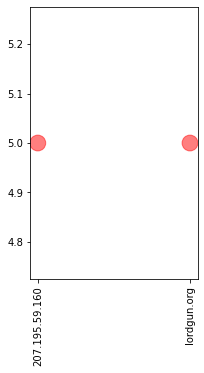

In [61]:
plt.figure(figsize = (3,5))

plt.scatter(dff[0].value_counts().index[0:7],
            dff[0].value_counts().values[0:7],
            s =  dff[0].value_counts().values[0:7]*50,
                  color='red', 
                 alpha=0.5)

plt.xticks( dff[0].value_counts().index[0:7],rotation='vertical');